## Advanced Lane Finding Project
The goals / steps of this project are the following:
 * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 * Apply a distortion correction to raw images.
 * Use color transforms, gradients, etc., to create a thresholded binary image.
 * Apply a perspective transform to rectify binary image ("birds-eye view").
 * Detect lane pixels and fit to find the lane boundary.
 * Determine the curvature of the lane and vehicle position with respect to center.
 * Warp the detected lane boundaries back onto the original image.
 * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 0. Auxiliary section

Here I am including required modules and setting useful parameters.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math, os, glob

%matplotlib inline

# Shape and size of the images.
image_shape = cv2.imread('test_images/test1.jpg').shape
image_size = (image_shape[1], image_shape[0])

In [2]:
# Required preparations to process video.
import imageio

imageio.plugins.ffmpeg.download()

### 1. Camera Calibration

The code for this step is below in the next 3 cells of the IPython notebook.

#### 1.1. Finding chessboards

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, **objp** is just a replicated array of coordinates, and **objpoints** will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.

**imgpoints** will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.
                
I then used the output **objpoints** and **imgpoints** to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. 

In [3]:
def camera_calibration(camera_cal_dir, nx, ny):
    # Create the grid array of object points.
    # (0, 0, 0), (0, 1, 0), ..., (nx-1, ny-1, 0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    
    images = glob.glob(os.path.join(camera_cal_dir, '*.jpg'))

    img_shape = None
    
    for fname in sorted(images):

        img = cv2.imread(fname)

        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
        if not img_shape:
            img_shape = img.shape[0:2]
            print('{}: assumed shape {}.'.format(fname, img.shape[0:2]))
        else:
            if img_shape != img.shape[0:2]:
                print('{}: Image shape missmatch ({}!={}).'.format(fname, img_shape, img.shape[0:2]))
        
    print("Total images: {}, found chessboard: {}".format(len(images), len(imgpoints)))
    
    return cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)

#### 1.2. Helper *camera_undistort* Function

In order to incapsulate the complexity of dealing with camera calibration parameters, I have created a helper function (**camera_undistort()**) that takes only one argument that is the image to process. 

The camera calibration parameters are stored in **calibration_result** global variable.

*Note that it turned out that not on all the calibration images the 9x6 chess board can be found. The imsages where the chess board is not detected are ignored.*

*Also, it turned out that the size of the images are a bit different. This difference is ignored.*

In [4]:
calibration_result = camera_calibration('camera_cal', 9, 6)

def camera_undistort(img):
    ret, mtx, dist, rvecs, tvecs = calibration_result
    
    return cv2.undistort(img, mtx, dist, None, mtx)

camera_cal/calibration1.jpg: assumed shape (720, 1280).
camera_cal/calibration15.jpg: Image shape missmatch ((720, 1280)!=(721, 1281)).
camera_cal/calibration7.jpg: Image shape missmatch ((720, 1280)!=(721, 1281)).
Total images: 20, found chessboard: 17


#### 1.3. Undistorting a test image

At last I applied the calculated distortion correction to the test image (*camera_cal/calibration1.jpg*) using the cv2.undistort() function and obtained the result is below.

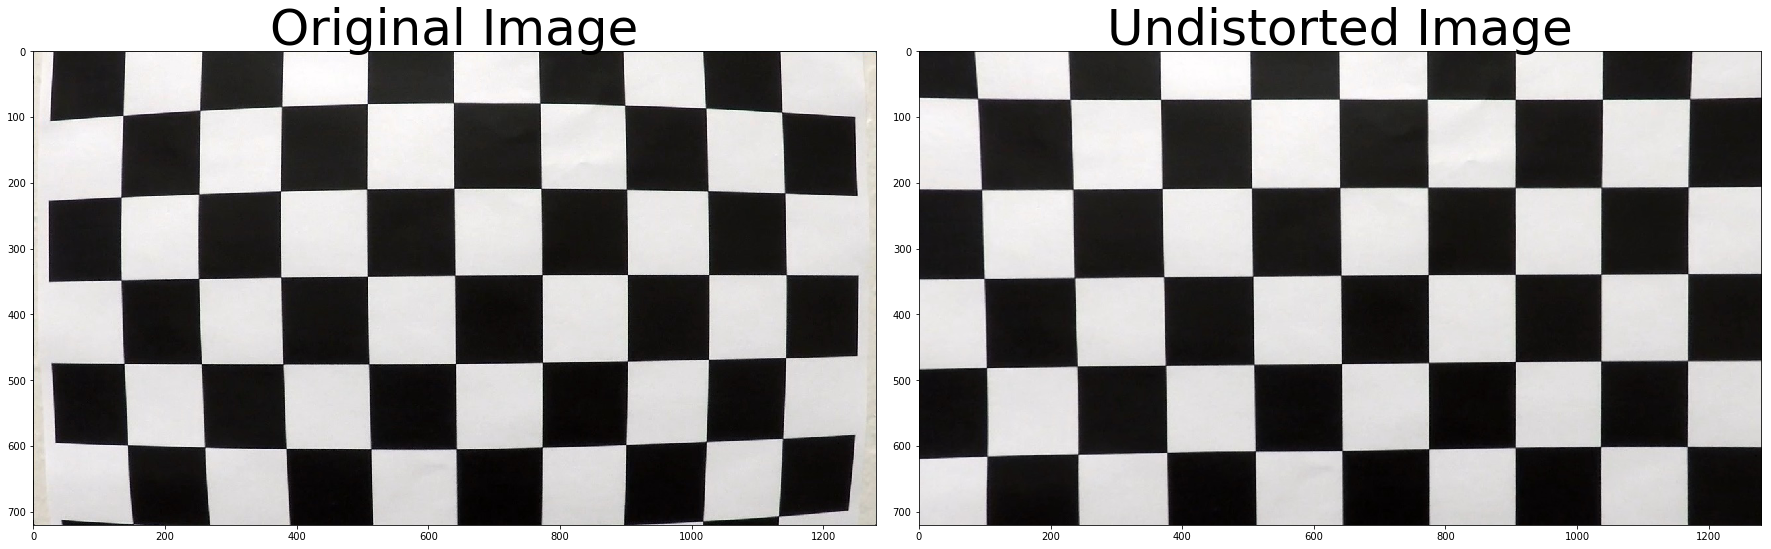

In [5]:
# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')

# Undistort test image using camera calibaration parameters.
undistorted = camera_undistort(img)

# Draw the distorted and undistorted images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 2. Pipeline (single images)

The pipeline includes:

1. Undistorting the image
2. Filtering Image
3. Unwarping Image
4. Identifying Lane Line and Fitting Polinomial
5. Combining and Drawing the Resulting Image

#### 2.1. Undistorting the image

The stup is performed using the camera_undistort() function introduced above. To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

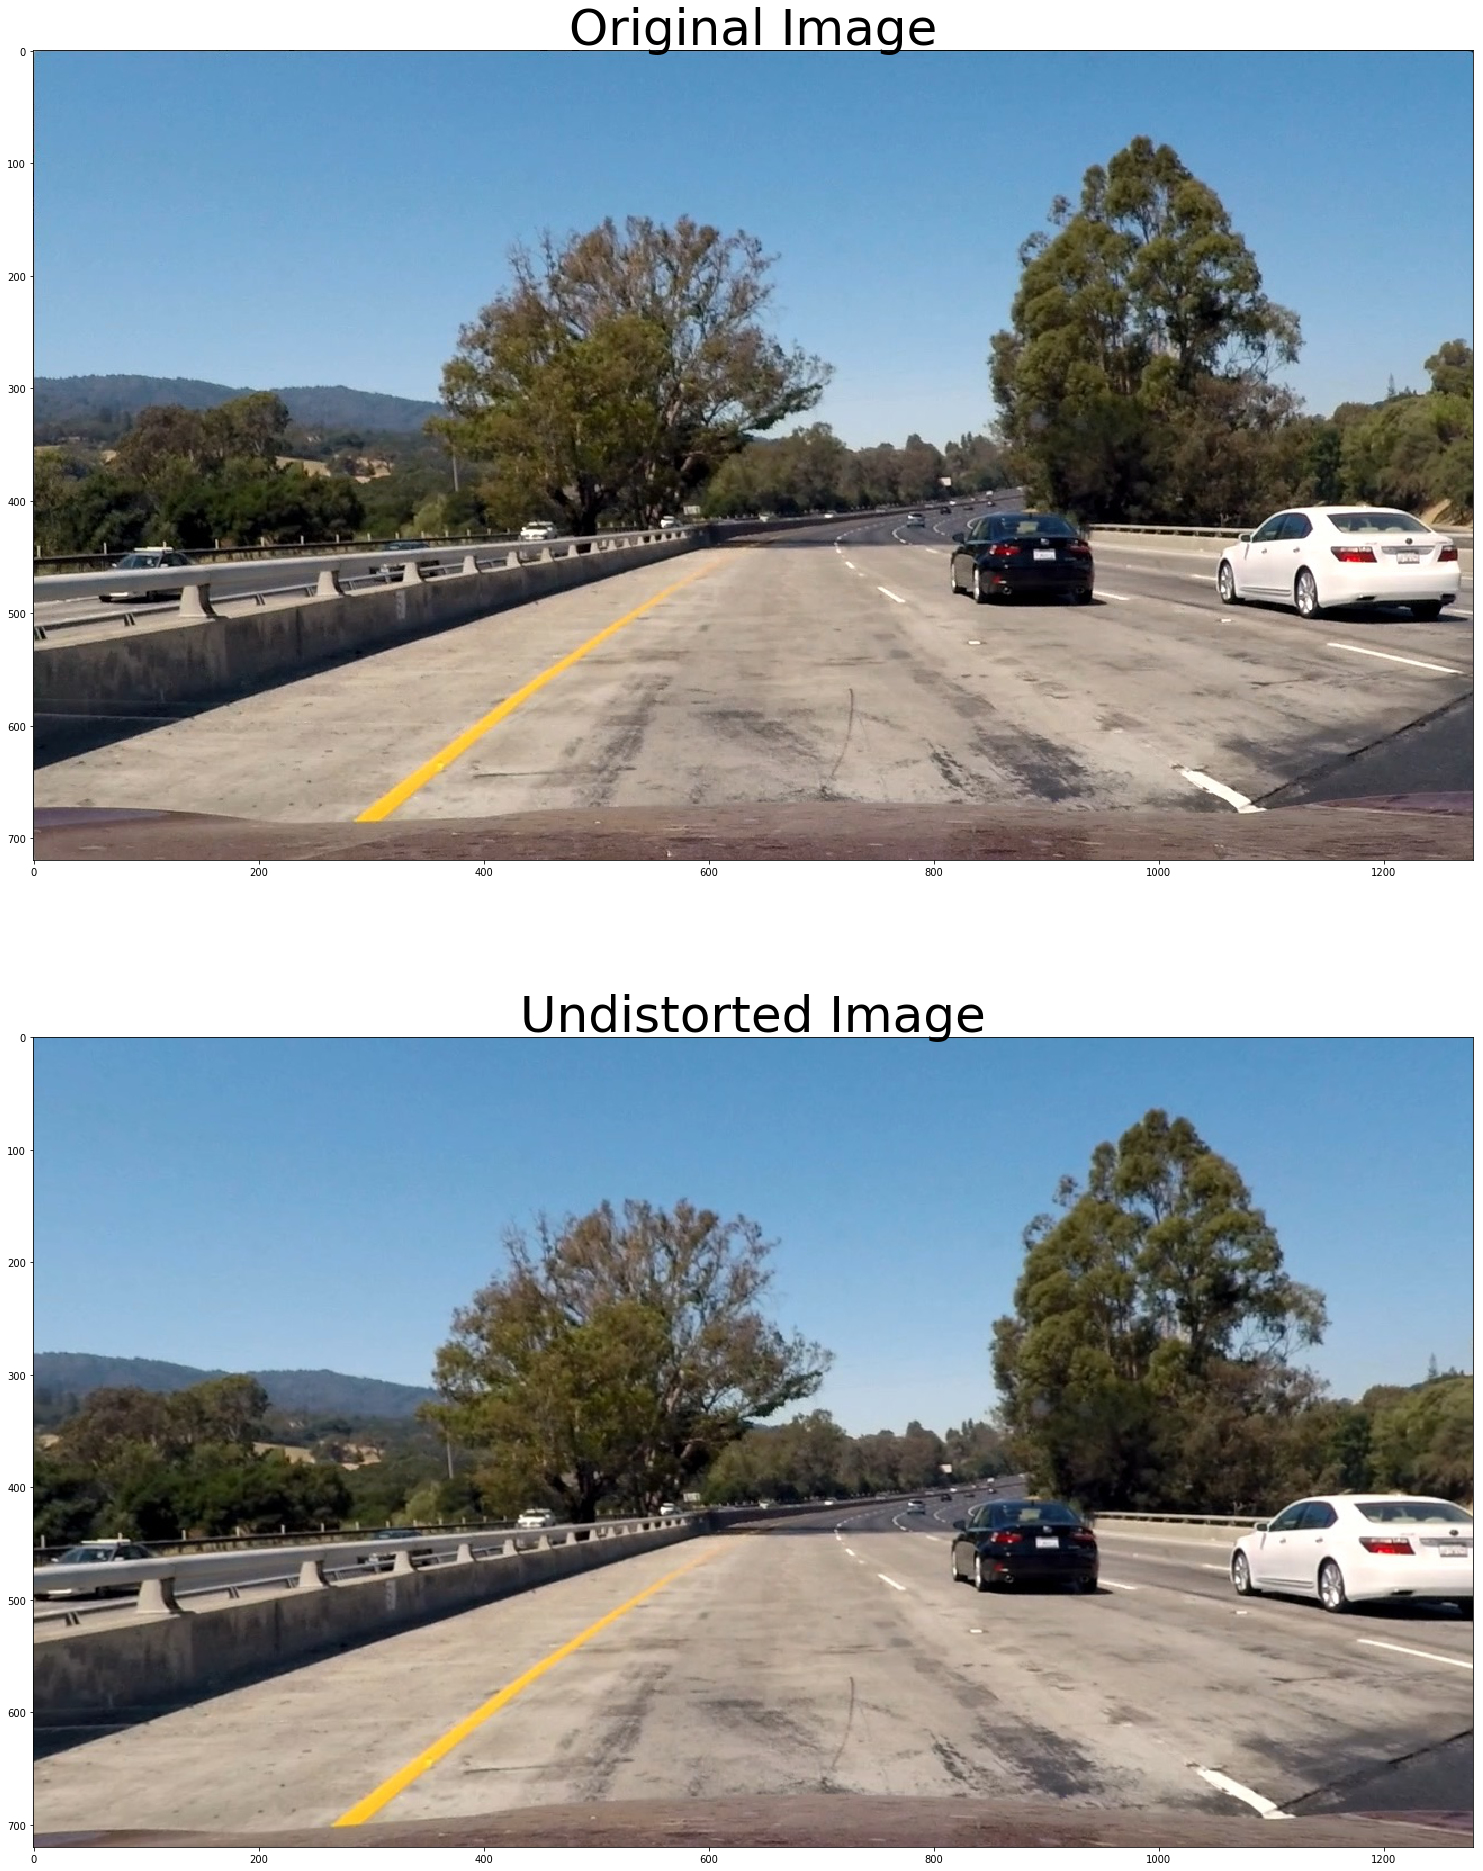

In [6]:
# Read in an image
img = cv2.imread('test_images/test1.jpg')

# Undistort test image using camera calibaration parameters.
undistorted = camera_undistort(img)

# Draw the distorted and undistorted images.
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 30))
f.tight_layout()

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 2.2. Filtering Image

I used a combination of color and gradient thresholds to generate the binary image. 

Namely, I have used the following filters: 
* Desriminate edges along X and Y axis (**discriminate_sobel_xy()** function)
* Desriminate magnitude and direction of the gradient (**discriminate_sobel_mag()** function)
* Desriminate yellow color (**discriminate_yellow()** function)
* Desriminate while color (**discriminate_white()** function)

##### 2.2.1. Gradient Thresholds Filters 

For the gradient thresholds filters I have played with parameters a bit and come up to the following values:
```
    sobel_x = sobel_abs_thresh(gray, orient='x', threshold_min = 10, threshold_max = 255, kernel_size=7)
    sobel_y = sobel_abs_thresh(gray, orient='y', threshold_min = 60, threshold_max = 255, kernel_size=7)
    
    sobel_mag = sobel_mag_thresh(gray, threshold_min=40, threshold_max=255, kernel_size=7)
    sobel_dir = sobel_dir_thresh(gray, threshold_min=.65, threshold_max=1.05, kernel_size=7)
```    
I have checked some works in the internet and it looks like the thresholds there are the same or similar.

##### 2.2.2. Color Filters

For the color filters I have chosen to use HVS space as it better preserves color properties important for filtering with changing illumination. 

Then I used http://colorizer.org to identify the ranges of the colors in the HVS space. The color thresholds I have chosen are:
```
    # While from (0,0,190) to (127,27,255) in HVS
    color_white = color_thresh(hsv_image, (0,0,190), (127,27,255))

    # Yellow from (0,90,180) to (50,255,255) in HVS
    color_yellow = color_thresh(hsv_image, (0,90,180), (50,255,255))
```

##### 2.2.3. Weighting Filter Results

It turned out that the performance of the filters is not the same. While yellow is a very reliable filter, filter of the gradiend magnitude and direction does not work as well for me.

Each of the above 4 filters provides bitmap as the result. To take this filter performance information into account I have decided to use a weighted sum of the filters. For the resulted wieghted sum I am using another threshold to generate resulted bitmap.

The weights and threshold I have chosen eventually are in the statement below:
```
    combined_result = np.clip(0.75*white_result + 1*yellow_result + 
                              0.75*sobel_xy_result + 0.5*sobel_mag_result, 0., 1.)

    color_binary[(combined_result >= 0.75)] = 1.
```

This functionality is implemented in **filter_image()** function.

##### 2.2.4. Debugging Approach

For the debugging purposes I am passing an optional paramters **results** (set to None by default) to filter_image() and some other fucntions.

If results is not None, the function is storing the intermediate data into results that can be used for visualisation and analysis later.

In [7]:
#
# These function are copied from the class with minor changes.
#

# Define a function to threshold an image for a given range and Sobel kernel
def sobel_dir_thresh(gray, threshold_min=0, threshold_max=np.pi/2, kernel_size=3):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir, dtype=np.uint8)
    binary_output[(absgraddir >= threshold_min) & (absgraddir <= threshold_max)] = 1

    # Return the binary image
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def sobel_abs_thresh(gray, orient='x', threshold_min=0, threshold_max=255, kernel_size=3):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel, dtype=np.uint8)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= threshold_min) & (scaled_sobel <= threshold_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def sobel_mag_thresh(gray, threshold_min=0, threshold_max=255, kernel_size=3):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag, dtype=np.uint8)
    binary_output[(gradmag >= threshold_min) & (gradmag <= threshold_max)] = 1

    # Return the binary image
    return binary_output

# Desriminate edges along X and Y axis
def discriminate_sobel_xy(gray):
    sobel_x = sobel_abs_thresh(gray, orient='x', threshold_min = 10, threshold_max = 255, kernel_size=7)
    sobel_y = sobel_abs_thresh(gray, orient='y', threshold_min = 60, threshold_max = 255, kernel_size=7)
    
    result = np.zeros_like(gray, dtype=np.float64)
    result[(sobel_x == 1) & (sobel_y == 1)] = 1.
    
    return result
    
# Desriminate magnitude and direction of the gradient
def discriminate_sobel_mag(gray):
    sobel_mag = sobel_mag_thresh(gray, threshold_min=40, threshold_max=255, kernel_size=7)
    sobel_dir = sobel_dir_thresh(gray, threshold_min=.65, threshold_max=1.05, kernel_size=7)

    result = np.zeros_like(gray, dtype=np.float64)
    result[((sobel_dir == 1) & (sobel_mag == 1))] = 1.
    
    return result

In [8]:
# Auximilary function that filters pixes (encoded in HVS space) that 
# fit within a range [threshold_min, threshold_max].
def color_thresh(hsv_image, threshold_min, threshold_max):
    binary_output = np.zeros_like(hsv_image[...,0], dtype=np.uint8)
    
    binary_output[(hsv_image[...,0] >= threshold_min[0]) &
                  (hsv_image[...,1] >= threshold_min[1]) &
                  (hsv_image[...,2] >= threshold_min[2]) &
                  (hsv_image[...,0] <= threshold_max[0]) &
                  (hsv_image[...,1] <= threshold_max[1]) &
                  (hsv_image[...,2] <= threshold_max[2])] = 1
    
    return binary_output

# Desriminate white color
def discriminate_white(hsv_image):
    color_white = color_thresh(hsv_image, (0,0,190), (127,27,255))

    result = np.zeros_like(color_white, dtype=np.float64)
    result[((color_white == 1))] = 1.

    return result

# Desriminate yellow color
def discriminate_yellow(hsv_image):
    color_yellow = color_thresh(hsv_image, (0,90,180), (50,255,255))

    result = np.zeros_like(color_yellow, dtype=np.float64)
    result[((color_yellow == 1))] = 1.

    return result

In [9]:
# Apply filters to the original image.
def filter_image(image, results = None):     

    # Do some bluring before applying the filters.
    image = cv2.GaussianBlur(image, (5, 5), 0)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply all 4 filters.
    white_result = discriminate_white(hsv)
    yellow_result = discriminate_yellow(hsv)
    sobel_xy_result = discriminate_sobel_xy(gray)
    sobel_mag_result = discriminate_sobel_mag(gray)

    # Compute the weighted result.
    combined_result = np.clip(0.75*white_result + 1*yellow_result + 0.75*sobel_xy_result + 0.5*sobel_mag_result, 0., 1.)

    if results is not None:
        results['white'] = white_result
        results['yellow'] = yellow_result
        results['sobel_xy'] = sobel_xy_result
        results['sobel_mag'] = sobel_mag_result
        results['combined'] = combined_result
    
    # Make the resulting bitmap.
    color_binary = np.zeros_like(combined_result, dtype=np.uint8)
    color_binary[(combined_result >= 0.75)] = 1.
    
    color_binary = np.uint8(255.*color_binary)
    
    return color_binary

#### 2.3. Unwarping Image

##### 2.3.1. Vanishing Point and Unwarping Area

I have played with the test images (in test_image/) and identified the **vanishing point** that seams to work the best for them. To check that I was making sure that the width of the lane stays constant.

The **image area** that I have chosed to work with is starting at the bottom corners of the image and goes straight to the vanishing point, but stops below it (as the the image around the vanishing point can hardly be used).

So the values for the vanishing point and image are are:
```
vanishing_point = np.array([637., 422.])

image_area_corners = np.array([[0., 720.],
                               [545., 465.],
                               [730., 465.],
                               [1280., 720.]], 
                              dtype=np.float32)
```


##### 2.3.2. Warping and Uwarping

The image area is unwarped to the image of the same size as the original one (the image is called **birdview** below). I am using offset of 200px from left and right during the process.

I am defining 2 auxiliary functions to simplify the process (**unwarp_image()** and **warp_birdview()**) for unwarping and warping the image respectively.

In [10]:
# The vanishing point
vanishing_point = np.array([637., 422.])

# The image area to unwarp
image_area_corners = np.array([[0., 720.],
                               [545., 465.],
                               [730., 465.],
                               [1280., 720.]], 
                              dtype=np.float32)

birdview_x_offset = 200 # offset from sides for dst points
birdview_y_offset = 0   # offset from top and bottom for dst points

# The corners of the image to unwarp to
birdview_area_corners = np.array([[birdview_x_offset, image_size[1]-birdview_y_offset],
                                  [birdview_x_offset, birdview_y_offset], 
                                  [image_size[0]-birdview_x_offset, birdview_y_offset],
                                  [image_size[0]-birdview_x_offset, image_size[1]-birdview_y_offset]],
                                 dtype=np.float32)

warp_M = cv2.getPerspectiveTransform(image_area_corners, birdview_area_corners)
warp_M_inv = cv2.getPerspectiveTransform(birdview_area_corners, image_area_corners)

# Define a function that unwarps the image to birdview
def unwarp_image(image):
    return cv2.warpPerspective(image, warp_M, image_size)

# Define a function that warps the birdview back to image
def warp_birdview(birdview):
    return cv2.warpPerspective(birdview, warp_M_inv, image_size)

##### 2.3.3. Filtering Visualisation

The result of the filtering of the original image is visulised in the next cell. Here one can see how each of the filters is working and how the final warped and unwarped results looks like.

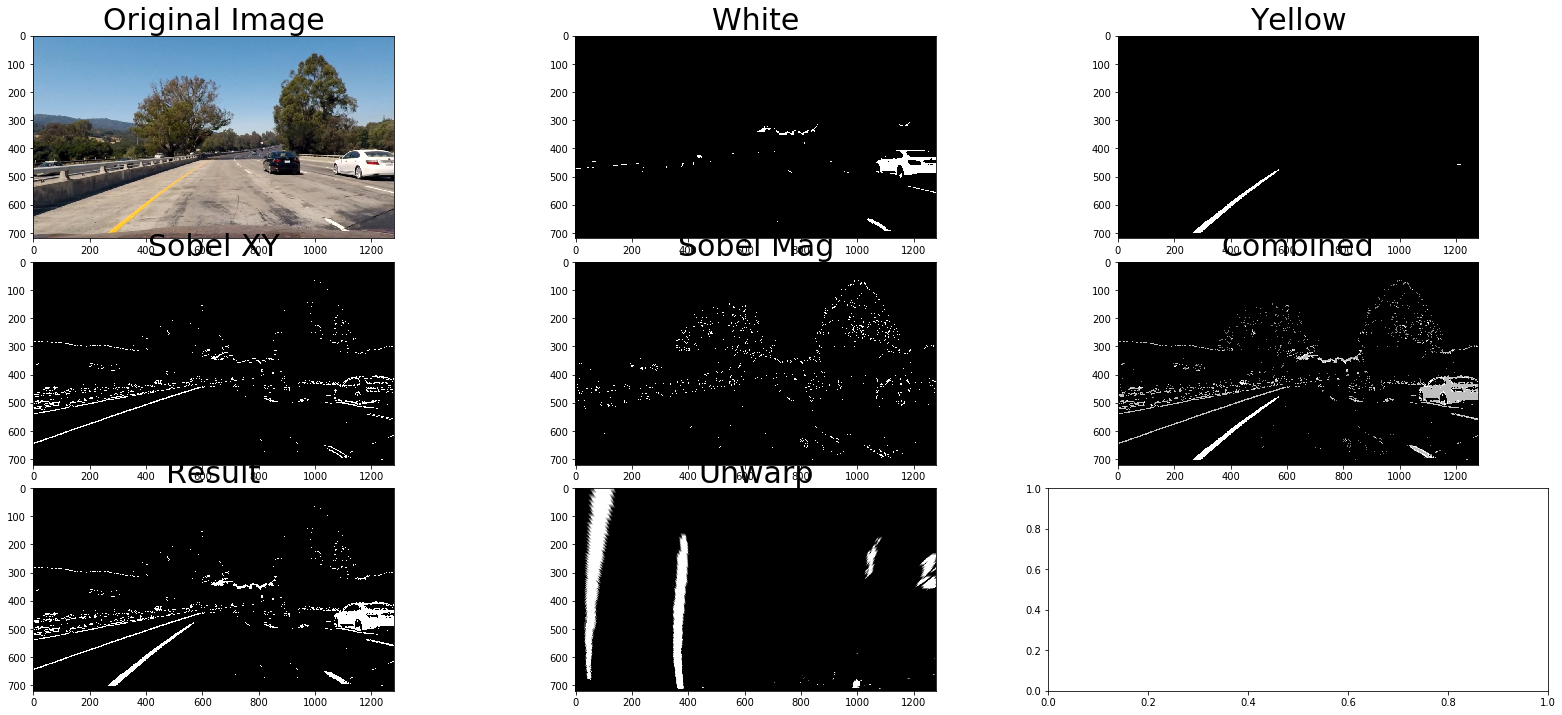

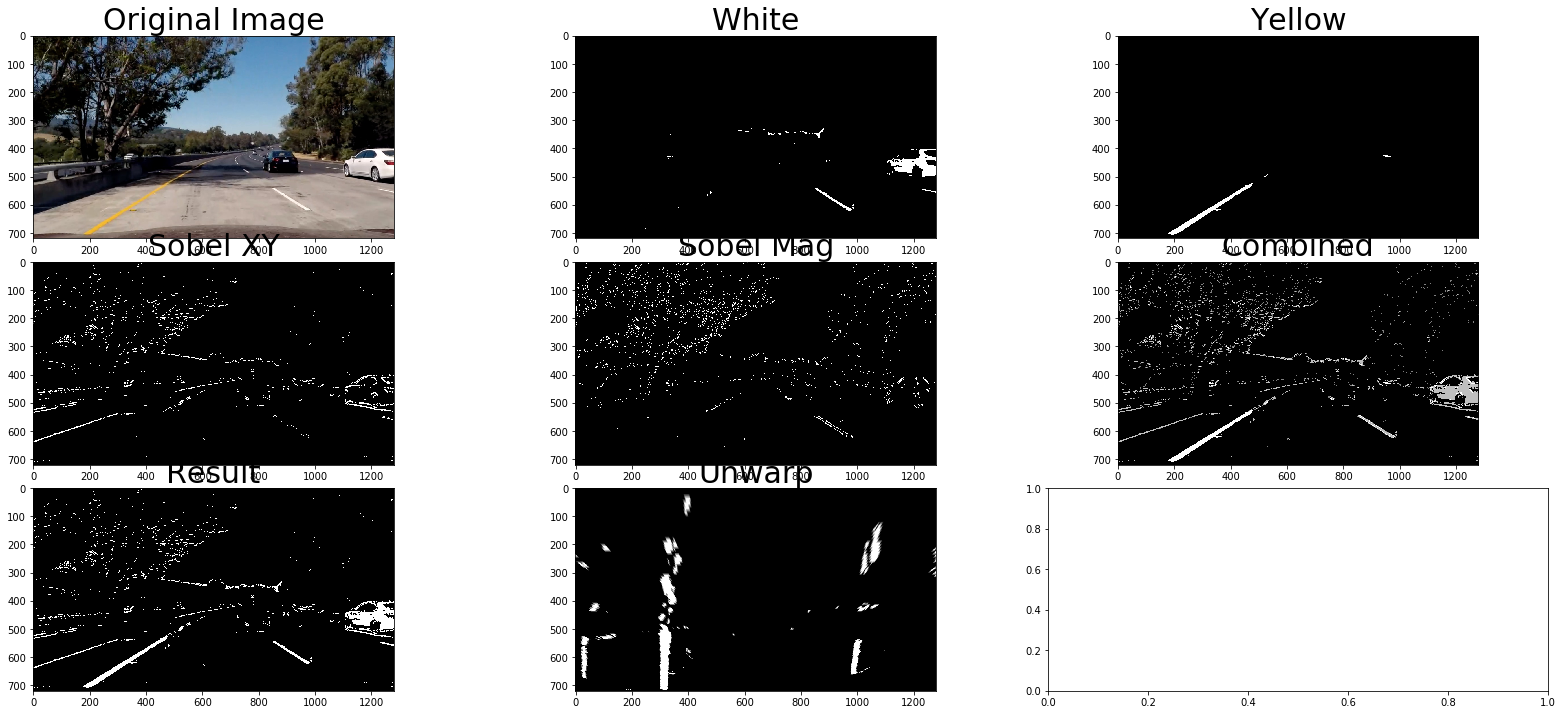

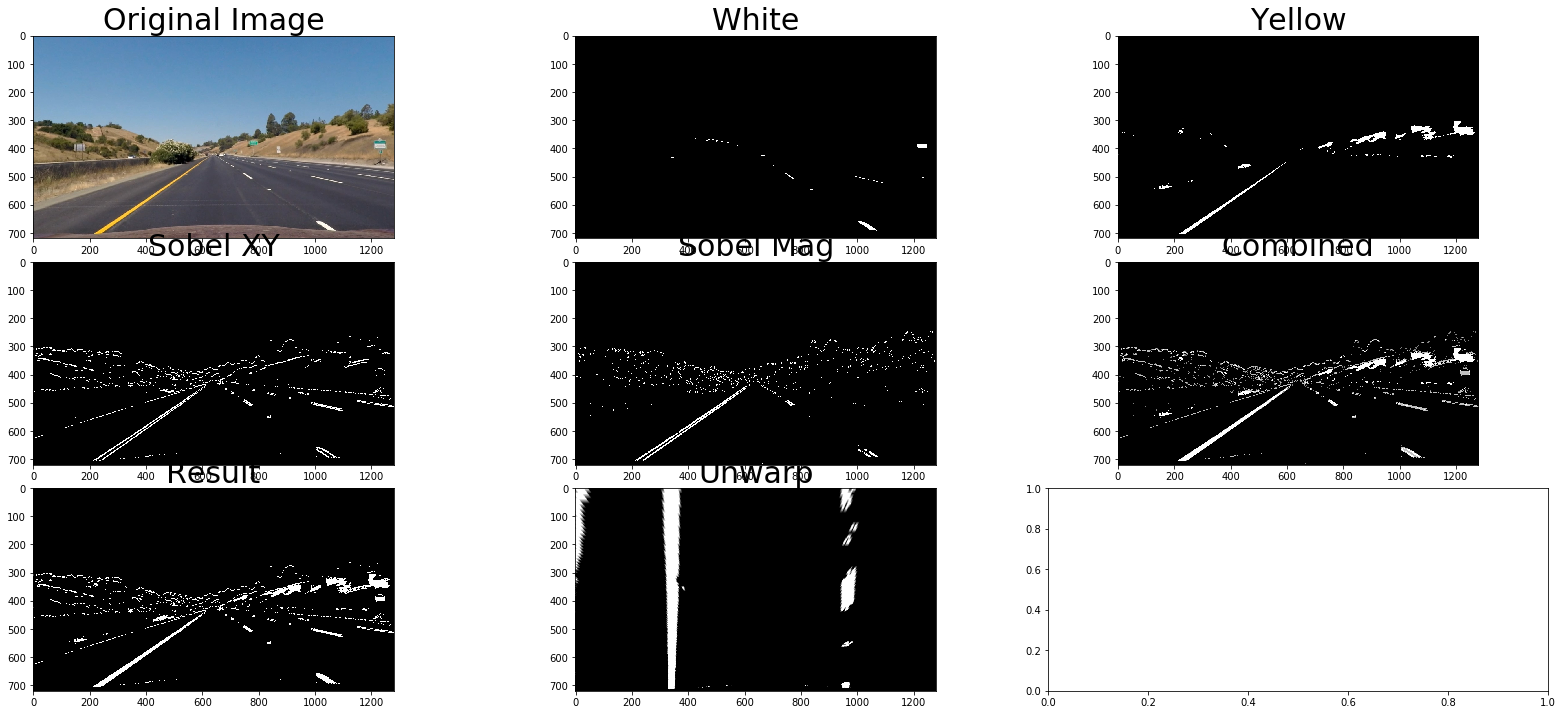

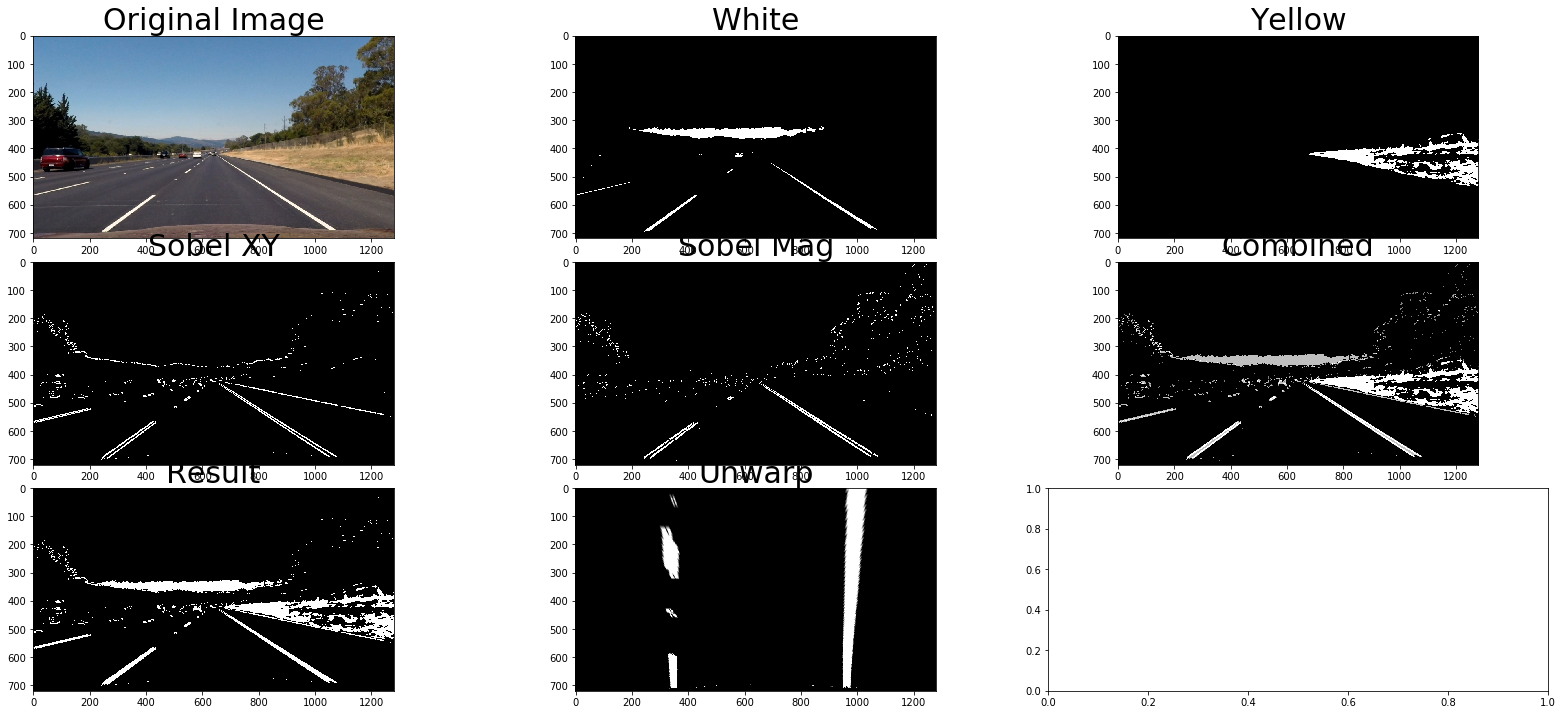

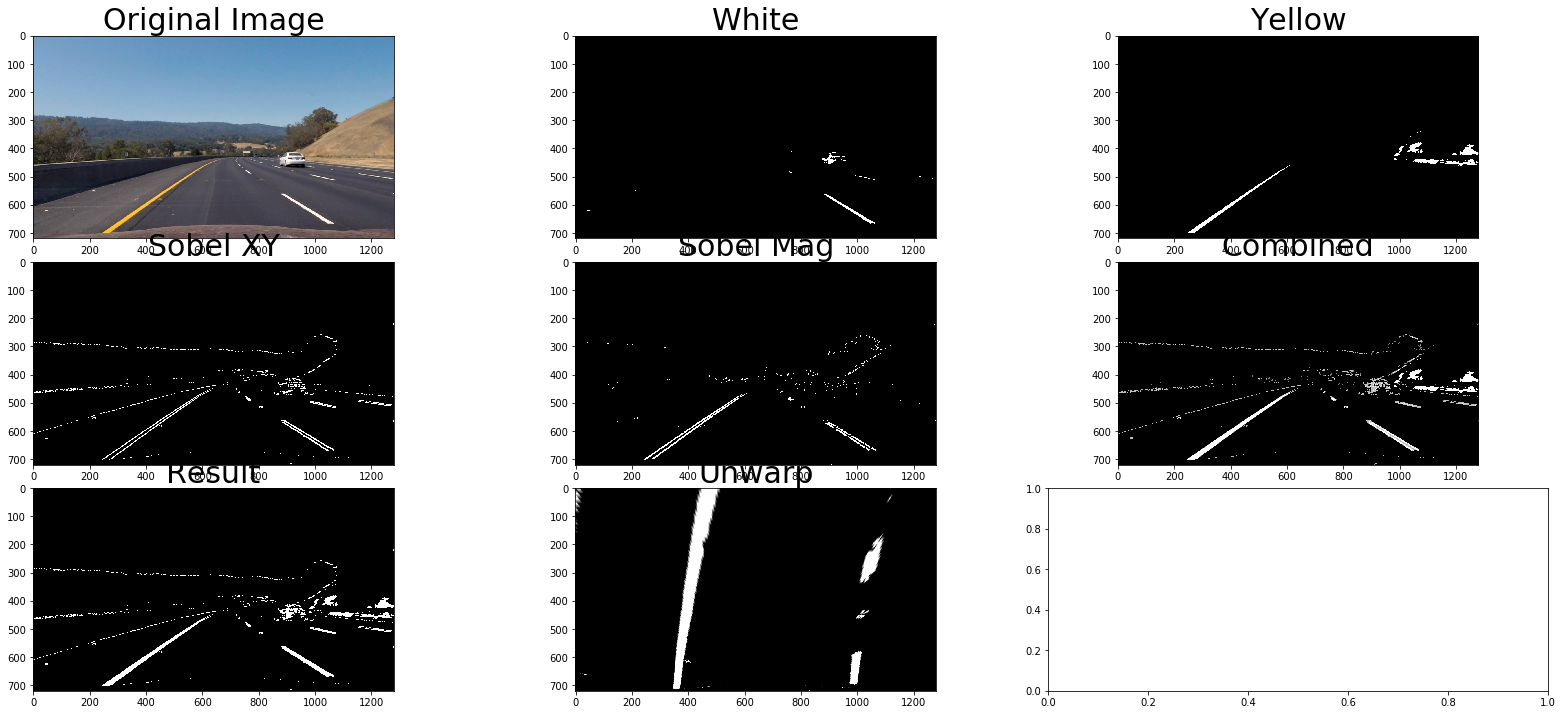

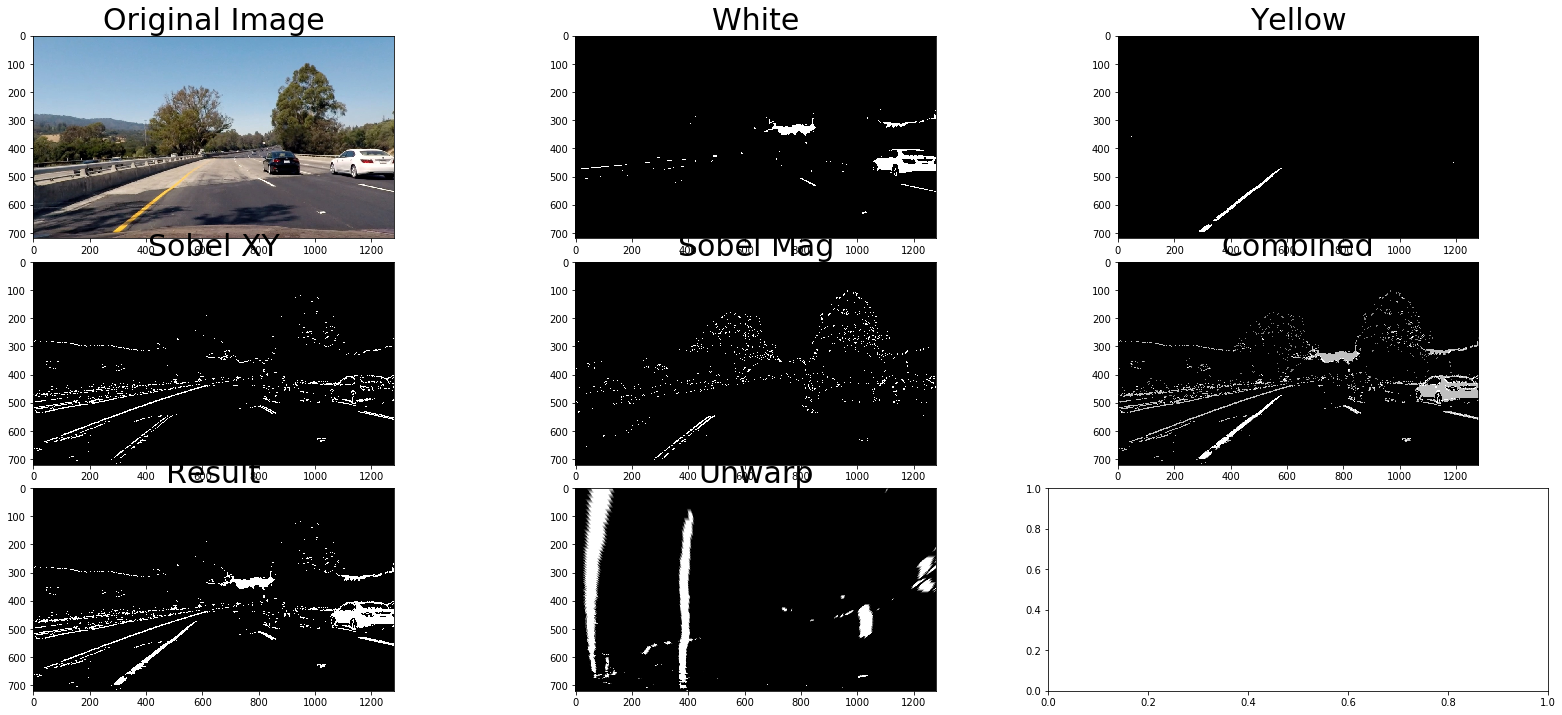

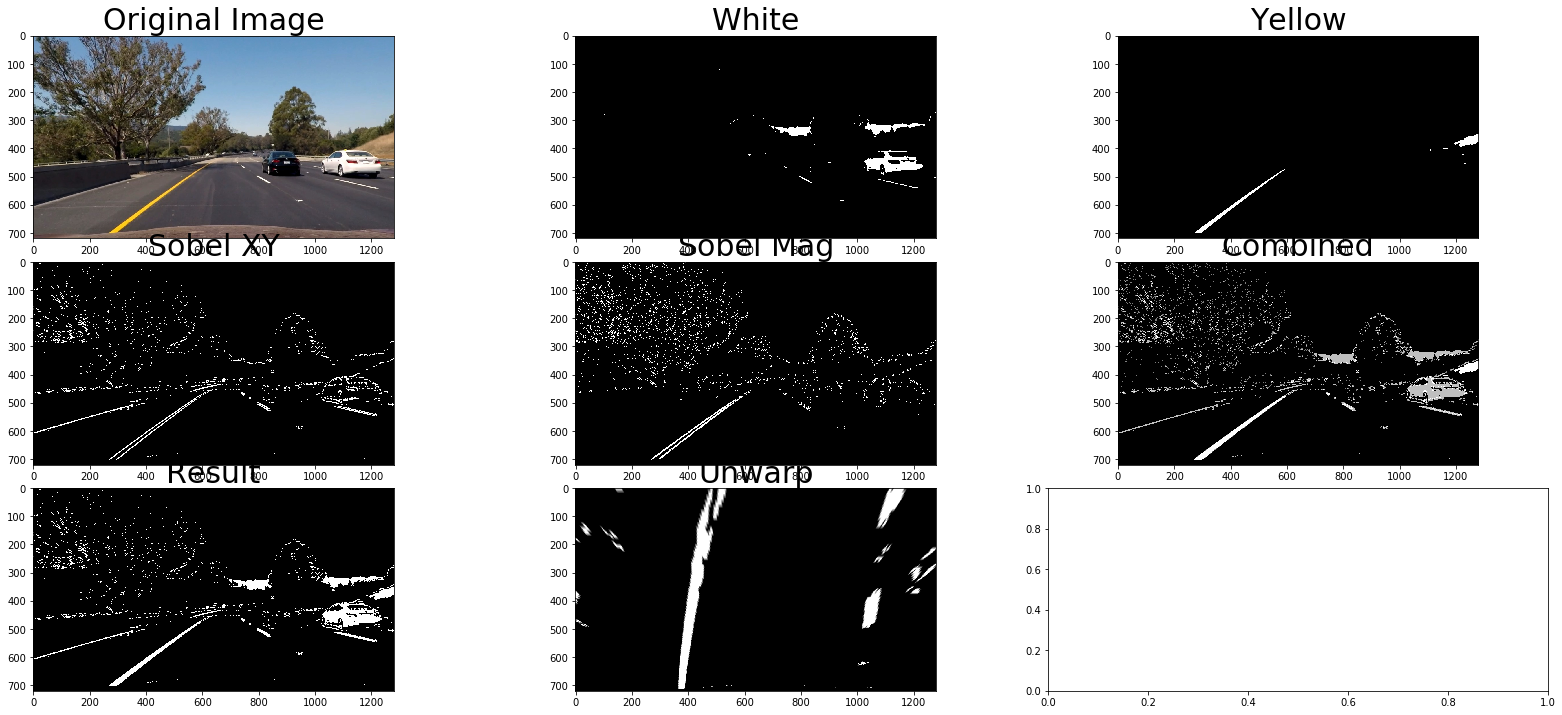

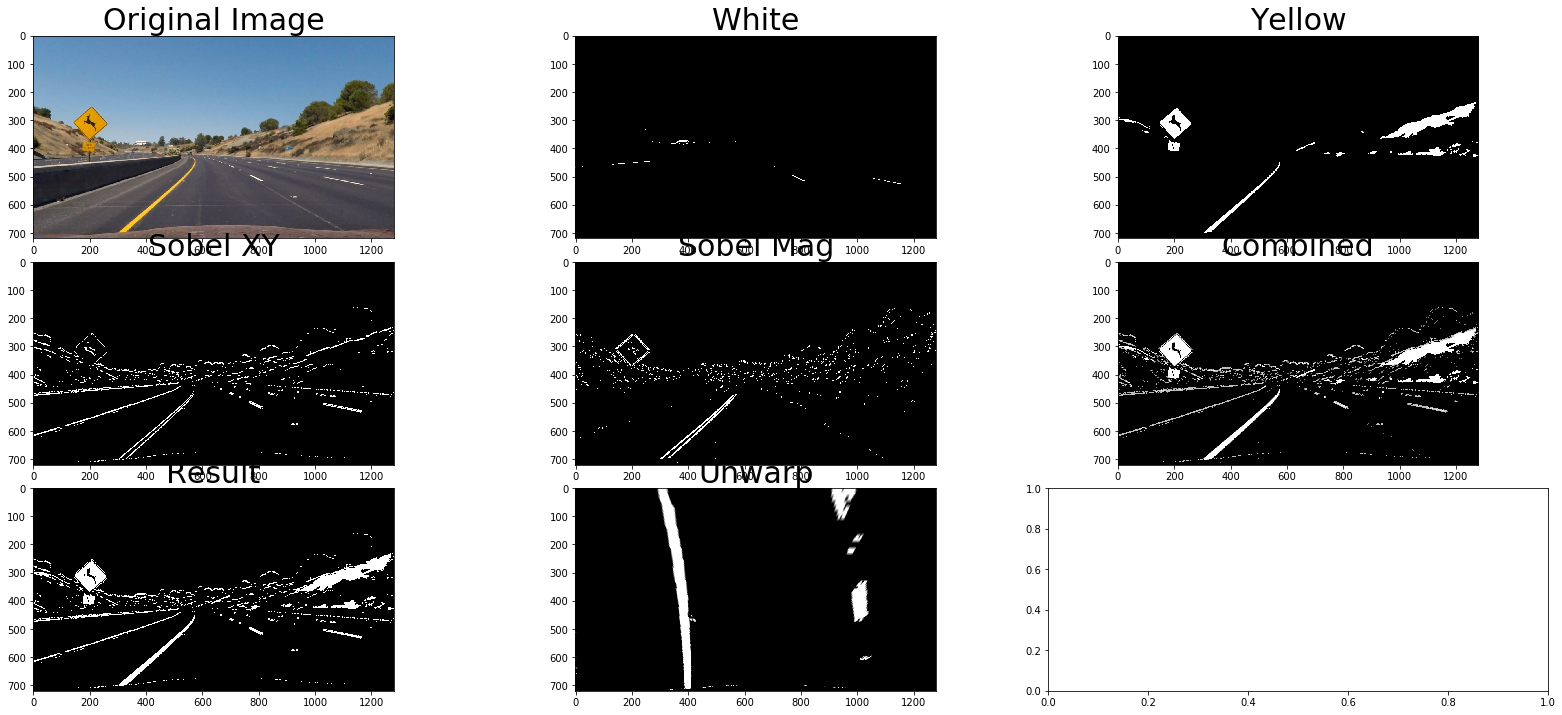

In [11]:
for fname in glob.glob(os.path.join('test_images', '*.jpg')):
    image = cv2.imread(fname)
    
    image = camera_undistort(image)

    results = {}
    processed_image = filter_image(image, results)
    
    # Draw the distorted and undistorted images.
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(22, 13))
    f.tight_layout()

    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)

    ax2.imshow(cv2.cvtColor(np.uint8(255. * results['white']), cv2.COLOR_GRAY2RGB))
    ax2.set_title('White', fontsize=30)

    ax3.imshow(cv2.cvtColor(np.uint8(255. * results['yellow']), cv2.COLOR_GRAY2RGB))
    ax3.set_title('Yellow', fontsize=30)

    ax4.imshow(cv2.cvtColor(np.uint8(255. * results['sobel_xy']), cv2.COLOR_GRAY2RGB))
    ax4.set_title('Sobel XY', fontsize=30)

    ax5.imshow(cv2.cvtColor(np.uint8(255. * results['sobel_mag']), cv2.COLOR_GRAY2RGB))
    ax5.set_title('Sobel Mag', fontsize=30)

    ax6.imshow(cv2.cvtColor(np.uint8(255. * results['combined']), cv2.COLOR_GRAY2RGB))
    ax6.set_title('Combined', fontsize=30)

    ax7.imshow(cv2.cvtColor(processed_image, cv2.COLOR_GRAY2RGB))
    ax7.set_title('Result', fontsize=30)

    ax8.imshow(cv2.cvtColor(unwarp_image(processed_image), cv2.COLOR_GRAY2RGB))
    ax8.set_title('Unwarp', fontsize=30)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.2)

#### 2.4. Identifying Lane Line and Fitting Polinomial

##### 2.4.1. Approach Overview

I have used the following approach to find lane lines.

The birdview image is devided at 10 not interlapping slides of the same size. On each of the slides a location where lane line is is detected. It is possible that no lane line points are identified on some slides. In such case it is assumed that this slide produced no result.

Process is performed separately for the left and right lane lines from bottom to top (as image is less desturted at the bottom).

The result of the process is up to 10 points for left and up to 10 points for right lane lines. The procedure is performed by **detect_lanes()** function.

Then the information is compined with the information from the previous frames and a polynomial is fitted through the detected points. Using the polinomials for the left and right lana lines the curvature and position are determined. 

##### 2.4.2. Apriori Knowledge

As the process is performed many times for consequent frames, it is reasonable to use information from the previous frames to fix possible lack of information on the current frame.

Additionally, there are reasonable assumptions where that lane lines are even if there were no information from the previous frames is available. Namely, it is reasonable to assume that the left and right lane lines are at left right sides of the car somewhere around 1/4 and 3/4 of the image width.

Also, If a lane line was detected in a certain location on the previous frame, it is reasonable to assume that on the next slide it will be close to the previous one.

So, the descripted approaches are used to both find lane lines on the current frame and after they are found to  better estimate the actual location of lane lines (by using locations of lane lines from different frames). 

##### 2.4.3. Detecting Lane Lines

Implemented in **detect_lanes()** function.

1. For each of the 10 slides I am computing **score**. That is the count of set pixels in the same x position (for all y values of the slide) devided by the size of the slide (to have a materic that will be independent of the slide size).

2. For left and right lane lines I am computing the expected locations.

 2.1. If there is information from previous frames, I am using this information to predict the locations of the lane line on this slide.

 2.2. If this is not the first slide and lane line was identified on the previous slide, I am using the location from the previous slide for the expected locations as well.

 2.3. If no information about expected location is available, the default locations is used (1/4 and 3/4 of the image width for left and right resectively). 

 2.4. If more than one source of information is available for the expected location, average value of all of them is taken. Also, in this case more precise (narrower) "detection" and "search" gaussians are used to identify lane line pixels.

3. A "detection" guassian is applies with the center in the expected location and either default or more precise sigma.

 3.1. It is possible that after applyting the gaussian the cumulative value in the slide is too small. In this case, it is assumed that there is no lane line on this slide.

4. To find the actual location that matches the location of the lane line the best, a convolution with a "search" gaussian is performed and the location with maximum values is taken. 

##### 2.4.4. Fitting Lane Lines

Implemented in **fit_lanes()** function.

1. Locations of the lane lines detected on this frame are blanded with locations from the last 7 frames.

2. Second order polynomial is fitten for all these points for left and right lines.

3. Polinomial coefficients are averaged over 7 previous frames and the result is used as the result for this frame.

4. Curvature and position are calculated and returned.

In [12]:
# Frame number to visulaize.
frame_no = 0

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

In [19]:
# Numer of slides.
NUM_SLIDES = 10

# Threshold to filter our slides without lane lines.
MATCH_THRESHOLD = 0.02

# Wider and narrower sigmas for the detection gaussian.
DEFAULT_SIGMA = 40.
PRECISE_SIGMA = 30.

# Helper function to compute gaussian (failed to find standard one).
def gaussian(x, mu, sigma):
    return 1. / (sigma * np.sqrt(2.*np.pi)) * np.exp(-0.5*((x - mu) / sigma)**2)

# Helper function that generates a vector of values of gaussian in all points in [x_min, x_max)
def make_gaussian(x_min, x_max, mu, sigma):
    return gaussian(np.arange(x_min, x_max, dtype=np.float64), mu, sigma)

# Wider and narrower search gaussians to search lane line locations.
DEFAULT_SEARCH_PATCH = make_gaussian(0., 80., 80./2., 40.)
PRECISE_SEARCH_PATCH = make_gaussian(0., 80., 80./2., 20.)

# Default location of left and right lane lines.
DEFAULT_LEFT = image_size[0]/4.
DEFAULT_RIGHT = image_size[0]*3./4.

# Detect location of left and right lane lines on each of the slides.
def detect_lanes(image, results=None):
    global left_lane, right_lane
    
    # For the result.
    left_lane_x = []
    left_lane_y = []
    right_lane_x = []
    right_lane_y = []

    # Polinomial coefficients from the previous slide.
    la = left_lane.current_fit if left_lane.detected else None
    ra = right_lane.current_fit if right_lane.detected else None

    left = None
    right = None

    for i in range(NUM_SLIDES):        
        # Limits of the slide.
        y_top    = image_size[1]*(NUM_SLIDES-i-1)//NUM_SLIDES
        y_bottom = image_size[1]*(NUM_SLIDES-i)//NUM_SLIDES

        # 1. Compute the score.
        score = np.sum(image[y_top:y_bottom,:], axis=0) / (y_bottom-y_top)

        # Center of the slide 
        y = (y_top + y_bottom)/2.

        # 2. Determine expected locations of left and right lane lines.
        expected_lefts = []
        expected_rights = []

        # 2.2-3 If no informtion from previous slide, use default one.
        expected_lefts.append(left if left != None else DEFAULT_LEFT)
        expected_rights.append(right if right != None else DEFAULT_RIGHT)
        
        # 2.1. Get locations from previous frame.
        if la != None: expected_lefts.append(la[0]*y**2 + la[1]*y + la[2]) 
        if ra != None: expected_rights.append(ra[0]*y**2 + ra[1]*y + ra[2])

        # 2.4. Averaging expected location.
        expected_left = np.average(expected_lefts)
        expected_right = np.average(expected_rights)

        # 3. Tune gaussian sigmas.
        (left_sigma, left_search_patch) = (PRECISE_SIGMA, PRECISE_SEARCH_PATCH) if len(expected_lefts) > 1 else (DEFAULT_SIGMA, DEFAULT_SEARCH_PATCH)
        (right_sigma, right_search_patch) = (PRECISE_SIGMA, PRECISE_SEARCH_PATCH) if len(expected_rights) > 1 else (DEFAULT_SIGMA, DEFAULT_SEARCH_PATCH)

        # 3. Apply gaussian
        left_gaussian = make_gaussian(0, image_size[0], expected_left, left_sigma)
        left_score = left_gaussian * score

        if np.sum(left_score) >= MATCH_THRESHOLD:
            left_convolved = np.convolve(left_score, left_search_patch, mode='same')
            left = np.argmax(left_convolved)

            left_lane_x.append(left) 
            left_lane_y.append((y_top+y_bottom)/2)

        # 3.1. Filed to find lane line pixels.
        else:
            left = None
        
        # 3. Apply gaussian
        right_gaussian = make_gaussian(0, image_size[0], expected_right, right_sigma)
        right_score = right_gaussian * score

        if np.sum(right_score) >= MATCH_THRESHOLD:
            right_convolved = np.convolve(right_score, right_search_patch, mode='same')
            right = np.argmax(right_convolved)

            right_lane_x.append(right) 
            right_lane_y.append((y_top+y_bottom)/2)

        # 3.1. Filed to find lane line pixels.
        else:
            right = None

#        print "I: {}, el:{}, l:{}, er:{}, r:{}".format(i, expected_left, left, expected_right, right)
        
    # 4. Return result.
    return left_lane_x, left_lane_y, right_lane_x, right_lane_y

In [20]:
# Define conversions in x and y from pixels space to meters (from the class)
ym_per_pix = 30. / 720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 700 # meteres per pixel in x dimension

def find_curvature_m(yvals, xvals):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)

    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    return curverad

# Information of the bottom of the screen is used only (600px-720px)
BOTTOM_POSITION = 600

def find_position_m(yvals, left_fitx, right_fitx):
    left = np.average(left_fitx[yvals >= BOTTOM_POSITION])
    right = np.average(right_fitx[yvals >= BOTTOM_POSITION])
    center = (left + right)/2.
    
    position = vanishing_point[0]

    return (position - center)*xm_per_pix

In [21]:
# Updating detected points (7 last set of points kept).
def update_detected_points(lane, xs, ys):
    lane.allx = lane.allx[-6:] + [xs] if lane.allx != None else [xs]
    lane.ally = lane.ally[-6:] + [ys] if lane.ally != None else [ys]

    return sum(lane.allx, []), sum(lane.ally, [])

# Updating fitting coefficients (7 last coefficients kept).
def update_lane_fit(lane, fit):
    lane.detected = True
    lane.recent_xfitted = np.append(lane.recent_xfitted, [fit], axis=0) if lane.recent_xfitted != [] else [fit]
    lane.recent_xfitted = lane.recent_xfitted[-7:]
    
    # Averaging the coefficients.
    lane.current_fit = np.average(lane.recent_xfitted, axis=0)
    
    return lane.current_fit

def fit_lanes(image, results=None):
    # define y coordinate values for plotting
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    
    # Curving left or right - -1: left 1: right
    curve = 0
    
    # Set left and right as None
    left = None
    right = None
    
    # Find lanes from three repeated procedures with different window values
    left_lane_x, left_lane_y, right_lane_x, right_lane_y = detect_lanes(image, results)
    
    # 1. Update the points (mixing the 7 previous frames)
    left_lane_x, left_lane_y = update_detected_points(left_lane, left_lane_x, left_lane_y)
    right_lane_x, right_lane_y = update_detected_points(right_lane, right_lane_x, right_lane_y)
    
    # 2. Find the coefficients of polynomials
    left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
    right_fit = np.polyfit(right_lane_y, right_lane_x, 2)

    # 3. Update the polinomial coefficients (averaging the 7 previous frames)
    left_fit = update_lane_fit(left_lane, left_fit)
    right_fit = update_lane_fit(right_lane, right_fit)
    
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    # Find curvatures
    left_lane.radius_of_curvature = find_curvature_m(yvals, left_fitx)
    right_lane.radius_of_curvature = find_curvature_m(yvals, right_fitx)
    
    # Curvature is averaged for left and right lanes.
    curverad = (left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2.
    
    # Find curvatures
    position = find_position_m(yvals, left_fitx, right_fitx)
    
    return yvals, left_fitx, right_fitx, curverad, position

#### 2.5. Combining and Drawing the Resulting Image

The **draw_results()** is given all the required information that was caluclated on the previous steps. This function performs the following:

1. Visulaises the lane polygon on birdview image.
2. Warping birdview image back.
3. Combining the warped image of the lane polygon with the original image
4. Add required text labels regarding the curvature and position of the car.

In [25]:
# Draw the result
def draw_results(image, warped, yvals, left_fitx, right_fitx, curvature, position):
    global frame_no
    
    # 1. Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (127, 255, 0))
    
    # 2. Warp the blank back to original image space using auxiliary function
    newwarp = warp_birdview(color_warp)
    
    # 3. Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # 4. Add text labels regarding position, curvature and frame #.
    side = ""
    if position > 0: side = "right"
    elif position < 0: side = "left"
        
    text = "Position: {:.2f}m {}".format(abs(position), side)
    cv2.putText(result, text, (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
 
    text = "Curvature: {:.3f}km".format(curvature/1000.)
    cv2.putText(result, text, (0, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
    
    text = "#{}".format(frame_no)
    cv2.putText(result, text, (1150, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return result

In [26]:
# Helper function that starts the process
def process_reset():
    global left_lane, right_lane
    
    left_lane = Line()
    right_lane = Line()
    
    global frame_no
    
    frame_no = 0

def process_image(image, starting_frame=0):
    global frame_no
    
    frame_no += 1
    
    if frame_no < starting_frame:
        return image
    
    image = camera_undistort(image)

    lanes_bitmap = filter_image(image)
    
    birdview = unwarp_image(lanes_bitmap)
    
    # Find the lines fitting to left and right lanes
    results = {}
    yvals, left_fitx, right_fitx, curverad, position = fit_lanes(birdview, results)
    
    result = draw_results(image, birdview, yvals, left_fitx, right_fitx, curverad, position)
    
    # Return the original image with colored region
    return result

##### 2.5.1. Lane Line Fitting Visualisation

The lane line fitting steps are visulised by the next cell. 

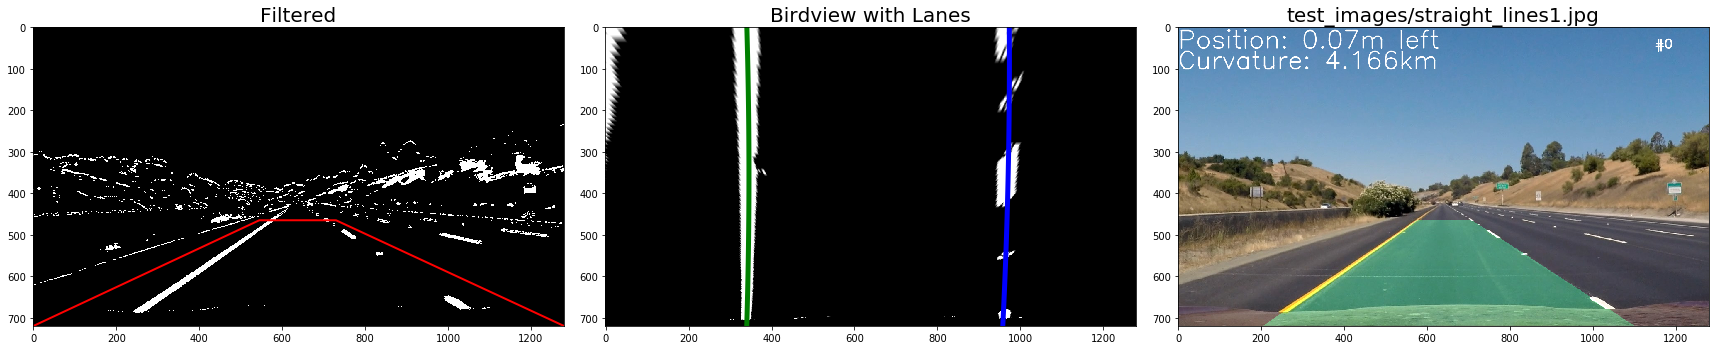

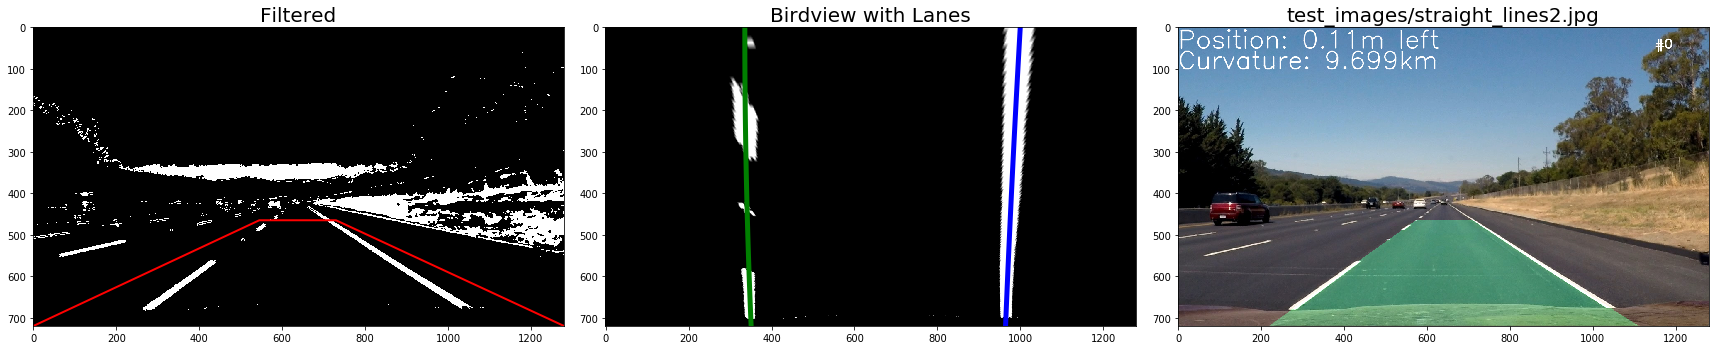

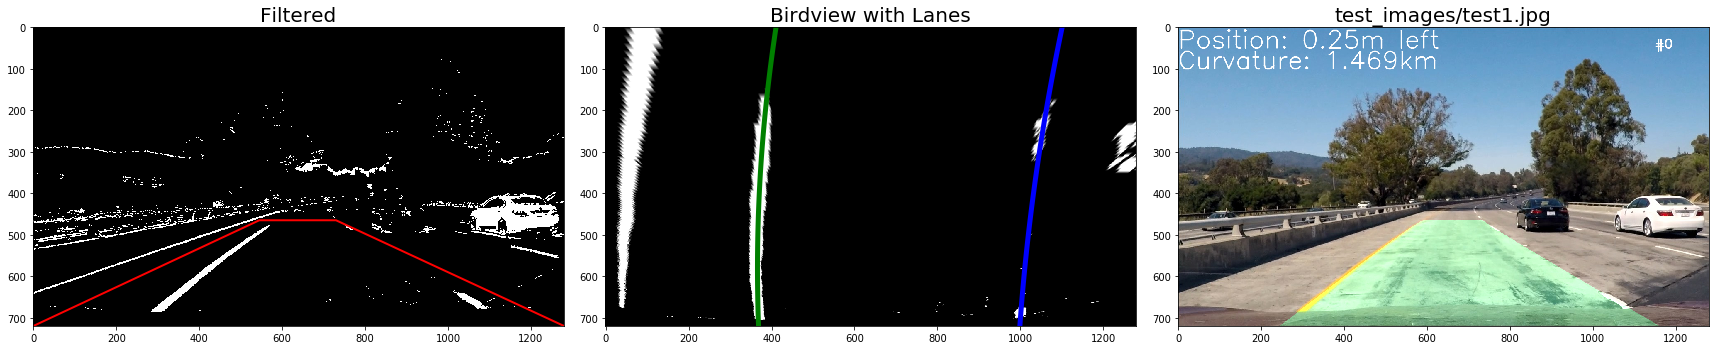

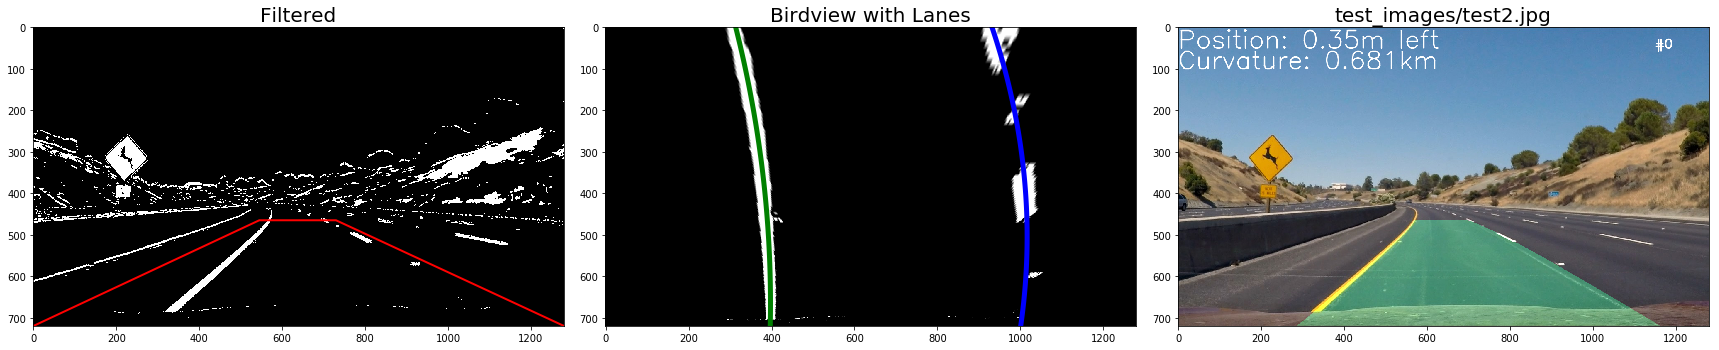

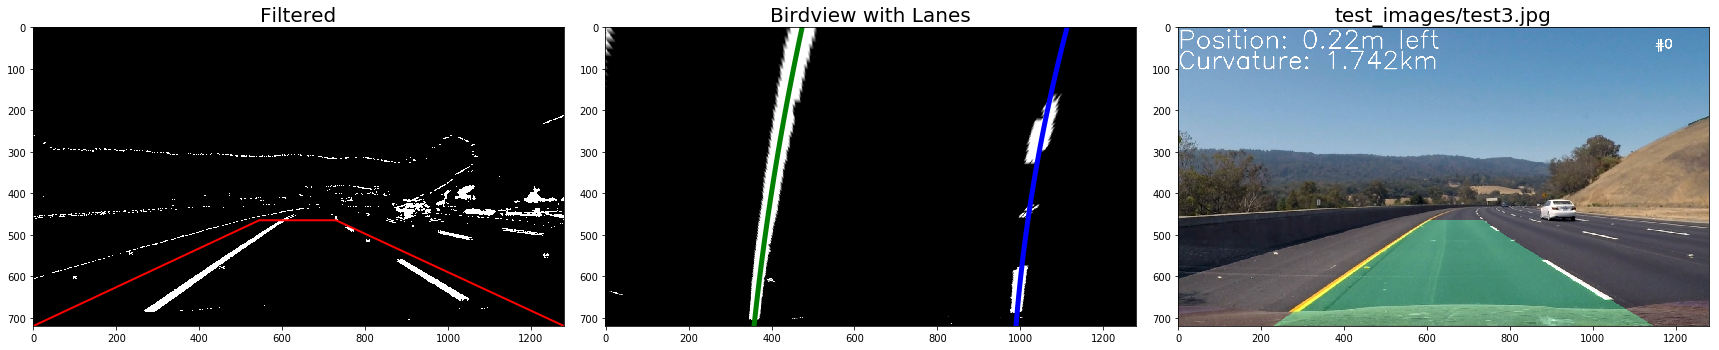

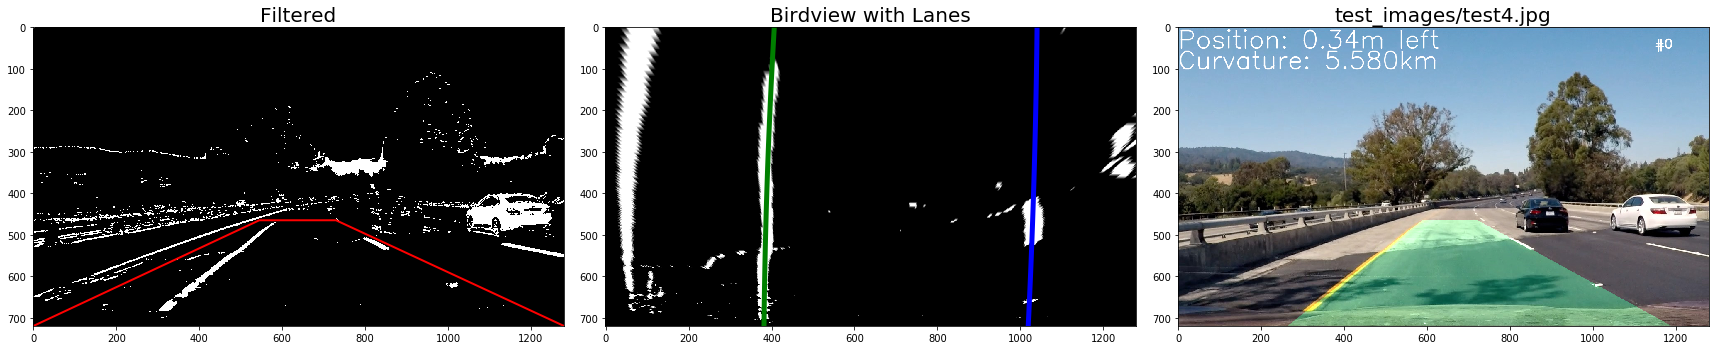

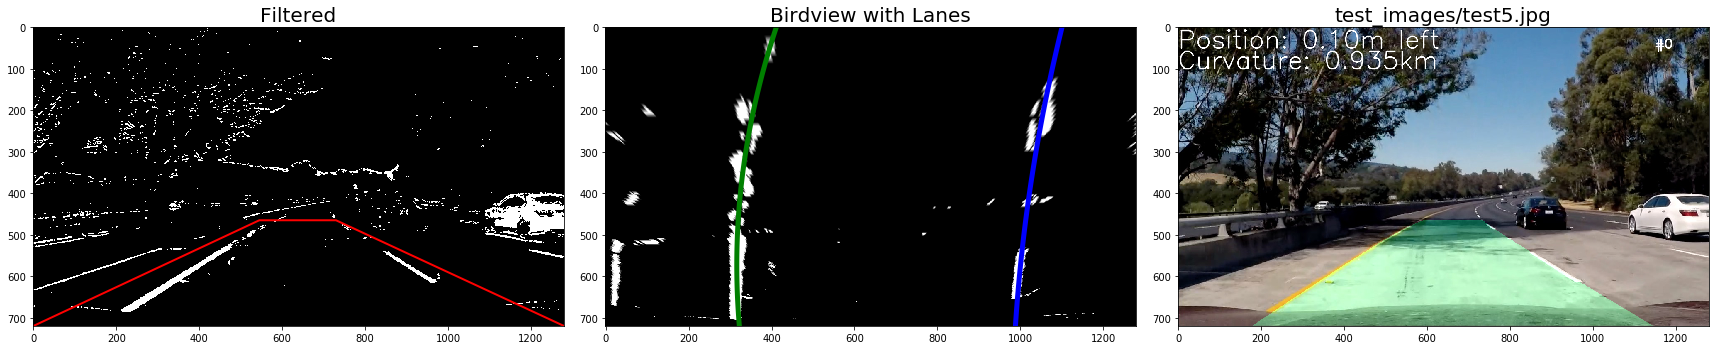

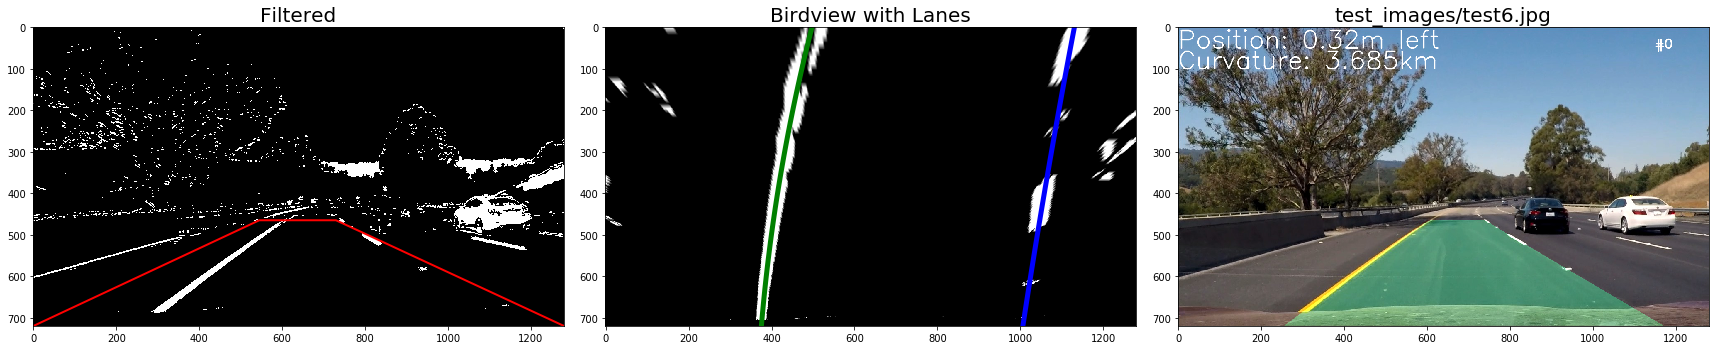

In [27]:

for fname in sorted(glob.glob(os.path.join('test_images', '*.jpg'))):

    image = cv2.imread(fname)
    
    fname_t = fname.replace('.jpg', '-{}.jpg').replace('test_images', 'output_images')
    
    # Apply pipeline to the image to create black and white image
    lanes_bitmap = filter_image(image)
    
    birdview = unwarp_image(lanes_bitmap)

    # Set up for the subplots
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    
    # Showing the image from pipeline with marked areas
    ax1.set_title('Filtered', fontsize=20)
    ax1.plot(image_area_corners[...,0], image_area_corners[...,1], 'r-', lw=2)
    ax1.imshow(lanes_bitmap, cmap='gray')
    
    cv2.imwrite(fname_t.format('Filtered'), cv2.cvtColor(lanes_bitmap, cv2.COLOR_GRAY2BGR))
    
    process_reset()

    results = {}
    # Find lanes from the warped image
    yvals, left_fitx, right_fitx, curverad, position = fit_lanes(birdview, results)
    
    ax2.plot(left_fitx, yvals, color='green', linewidth=5)
    ax2.plot(right_fitx, yvals, color='blue', linewidth=5)
    ax2.imshow(birdview, cmap='gray')
    ax2.set_title('Birdview with Lanes', fontsize=20)
    
    ax3.set_title(fname, fontsize=20)
    ax3.imshow(cv2.cvtColor(draw_results(image, birdview, yvals, 
                                         left_fitx, right_fitx, curverad, position), cv2.COLOR_BGR2RGB))

### 3. Project Video

Section with video to prepare the project video.

Video is published at https://youtu.be/vwivin4oW9M

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Helper function that converts RGB image to BGR and back after process_image() is finished.
def process_image_rgb(image):
    return cv2.cvtColor(process_image(cv2.cvtColor(image, cv2.COLOR_RGB2BGR)),cv2.COLOR_BGR2RGB)

In [29]:
process_reset()

video_output = 'project_video_output.mp4'
video_input = VideoFileClip("project_video.mp4")
video_clip = video_input.fl_image(process_image_rgb) #NOTE: this function expects color images!!

%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [09:55<00:00,  2.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 40s, sys: 3.58 s, total: 7min 44s
Wall time: 9min 58s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### 4. Discussion

Static vs Dinamic Vanishing Point
In theory the camera is fixing hard to the car and the road is flat, so the vanishing point should be fixed on the image and all good. But in reality on bumps and dips the car is car is changing the angle of the camera towards the road that make an effect of vanishing point going up and down.

It clearly better would be to identify / adopt vanishing point for each frame.

However, it looks like even the simple approach with fixed vanishing point works rather well. Also, taking into account that I am late with the task, I have decided with fixed vanishing point approach.